<a href="https://colab.research.google.com/github/chetan015/deep-learning/blob/master/Assignment-09/Assignment-09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

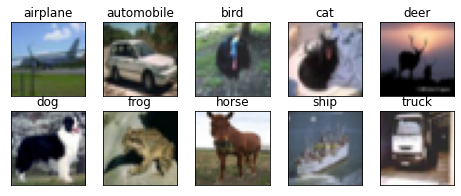

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
images = []
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
    images.append(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model
def create_model():
  model = Sequential()

  # RCF 3x3
  model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3),border_mode="same")) #32
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  # RCF 5x5
  model.add(Convolution2D(64, 3, 3,border_mode="same"))#32
  model.add(Activation('relu'))
  model.add(Dropout(0.2))


  #Transition Block
  # RCF 10x10
  # Reduce to 16 channels
  model.add(MaxPooling2D(pool_size=(2,2))) 
  # model.add(Convolution2D(16,1))#16


  # RCF 12x12
  model.add(Convolution2D(64, 3, 3,border_mode="same"))#16
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))


  # RCF 14x14
  model.add(Convolution2D(128, 3, 3,border_mode="same"))#16
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  #Transition Block
  # RCF 28x28
  # Reduce to 16 channels
  model.add(MaxPooling2D(pool_size=(2,2))) #8
  # model.add(Convolution2D(16,1))

  # RCF 30x30
  model.add(Convolution2D(128, 3, 3,border_mode="same"))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  # RCF 32x32
  model.add(Convolution2D(128, 3, 3,border_mode="same",name="conv_final"))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))


  # Reduce to ten channels
  model.add(Convolution2D(10,1))

  # Add final convolution to reshape output layer to 1x10
  model.add(Convolution2D(10, 8, 8)) #1

  model.add(Flatten())
  model.add(Activation('softmax'))
  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Learning Rate scheduler to find optimal learning rate
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.006 * 1/(1 + 0.319 * epoch), 10)


In [11]:
model.summary()

NameError: ignored

In [0]:
# import os
# import tensorflow as tf
# from keras.callbacks import ModelCheckpoint
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.006.
390/390 [==============================] - 44s 114ms/step - loss: 1.5162 - accuracy: 0.4582 - val_loss: 1.5295 - val_accuracy: 0.4712
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0045489007.
390/390 [==============================] - 37s 94ms/step - loss: 0.9893 - accuracy: 0.6524 - val_loss: 1.1279 - val_accuracy: 0.6099
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036630037.
390/390 [==============================] - 37s 94ms/step - loss: 0.7824 - accuracy: 0.7255 - val_loss: 1.0558 - val_accuracy: 0.6510
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0030659172.
390/390 [==============================] - 36s 93ms/step - loss: 0.6675 - accuracy: 0.7658 - val_loss: 0.7341 - val_accuracy: 0.7488
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0026362039.
390/390 [==============================] - 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


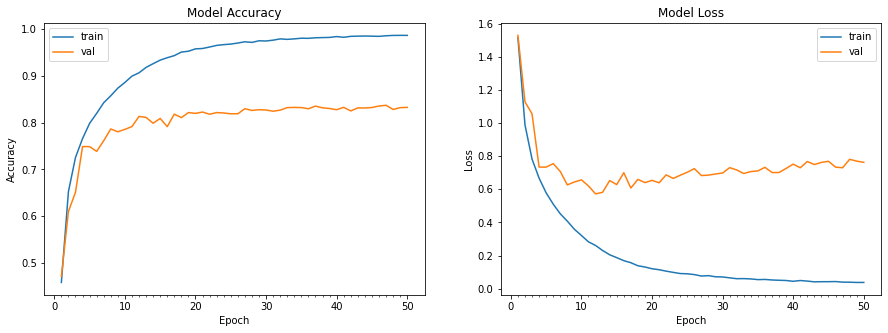

Accuracy on test data is: 83.26
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.006.
  2/390 [..............................] - ETA: 35s - loss: 0.0221 - accuracy: 0.9922

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


390/390 [==============================] - 37s 94ms/step - loss: 0.6291 - accuracy: 0.7899 - val_loss: 0.6503 - val_accuracy: 0.7735
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0045489007.
390/390 [==============================] - 37s 94ms/step - loss: 0.3514 - accuracy: 0.8746 - val_loss: 0.6770 - val_accuracy: 0.7748
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036630037.
390/390 [==============================] - 37s 94ms/step - loss: 0.2664 - accuracy: 0.9050 - val_loss: 0.6626 - val_accuracy: 0.7876
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0030659172.
390/390 [==============================] - 37s 94ms/step - loss: 0.2053 - accuracy: 0.9281 - val_loss: 0.6709 - val_accuracy: 0.7938
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0026362039.
390/390 [==============================] - 37s 94ms/step - loss: 0.1682 - accuracy: 0.9400 - val_loss: 0.5984 - val_accuracy

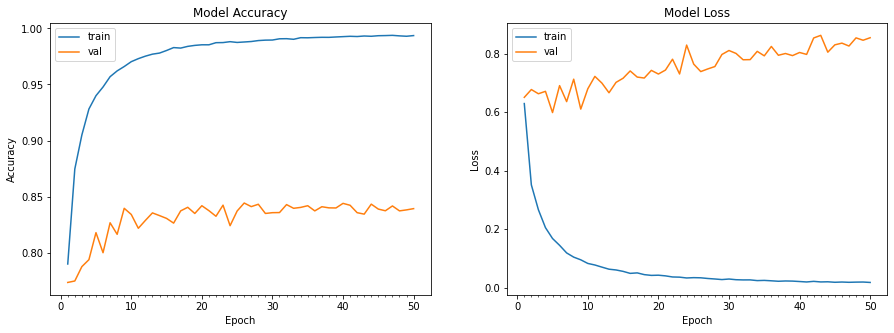

Accuracy on test data is: 83.93


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
weights_wo_cutout = ModelCheckpoint('model_weights_wo_cutout.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
# Train the model
model_wo_cutout = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[weights_wo_cutout,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_wo_cutout)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
datagen_w_cutout = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
weights_w_cutout = ModelCheckpoint('model_weights_w_cutout.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
# Train the model
model_w_cutout = model.fit_generator(datagen_w_cutout.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[weights_w_cutout,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_w_cutout)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))



In [0]:

def gradCam(imageID, model): 
  #print(preds[imageID])
  #print(class_idx)
  #find the class id of the prediction of Image
  class_idx = np.argmax(preds[imageID])
  class_output = model.output[:, class_idx]
  
  #get the last convolutional layer
  last_conv_layer = model.get_layer("conv_final")
  #get the gradients of the last layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  #pool the gradients over all the axes
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  testImage = test_features[imageID]
  testImage = testImage.reshape(1,32,32,3)
  pooled_grads_value, conv_layer_output_value = iterate([testImage])

  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  img = test_features[imageID]

  #build a heatmap 
  
  #average the weighted feature map
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  #RELU
  heatmap = np.maximum(heatmap, 0)
  #normalize between 0 and 1
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap.astype('float32')
  plt.imshow(heatmap)
  #superimpose the heatmap over original image
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.5, 0)
  
  #return the superimposed iaage
  return superimposed_img

In [0]:
model = create_model()
model.load_weights("model_weights_wo_cutout.hdf5")
score = model.evaluate(test_features, test_labels, verbose=0)
print(score)
print("Accuracy of the Model w/o Coutout is : %0.4f"%(score[1]))
model = create_model()
model.load_weights("model_weights_w_cutout.hdf5")
score = model.evaluate(test_features, test_labels, verbose=0)
print(score)
print("Accuracy of the Model w Coutout is : %0.4f"%(score[1]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3,

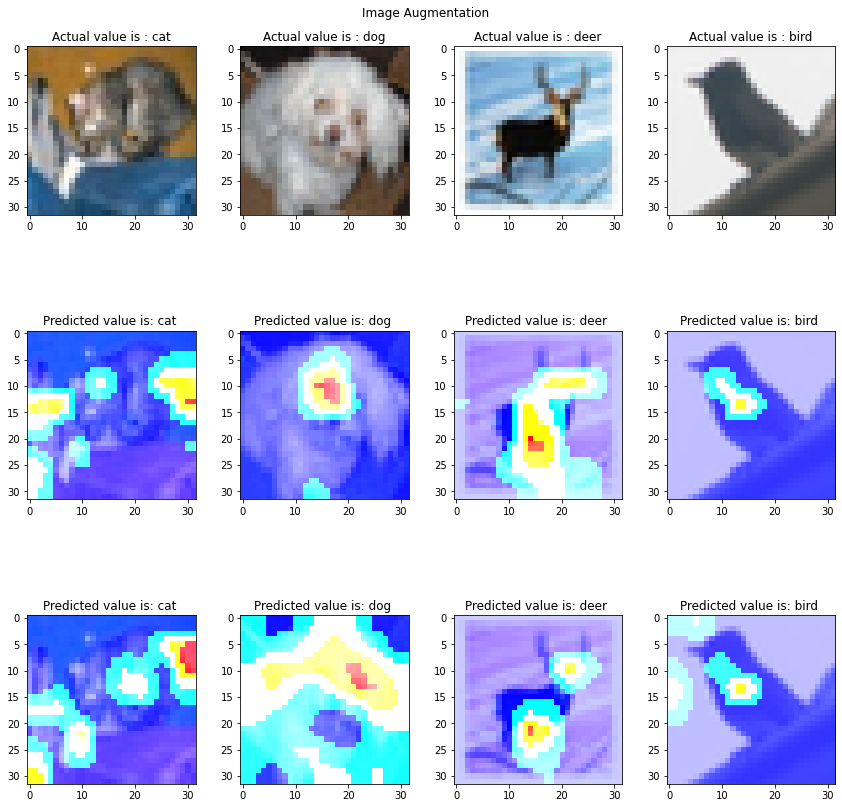

In [59]:
from google.colab.patches import cv2_imshow
from keras.models import load_model


imageIds = [0,1000,4120,8030]
#from a subplot of 5X5 images with each figure of 20X20
fig, ax = plt.subplots(3, 4, figsize = (12, 12))
fig.tight_layout()
#give title to sub plot
fig.suptitle('Image Augmentation')


#plot the original image
for i in range(len(imageIds)):
  #show the image
  ax[0,i].imshow(test_features[imageIds[i]])
  ax[0,i].set_title('Actual value is : %s' %(class_names[np.argmax(test_labels[imageIds[i]])]))



#for all the images print the heatmap of model w/o cutout
#load the model without cutout
model = create_model()
model.load_weights('model_weights_wo_cutout.hdf5')
preds = model.predict(test_features)

for i in range(len(imageIds)):
  #get b,g,r
  b,g,r = cv2.split(gradCam(imageIds[i], model))
  # switch it to rgb
  rgb_img = cv2.merge([r,g,b])     
  #img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  #uperimposed_img = gradCam(imageIds[i], model)
  #superimposed_img = cv2.resize(superimposed_img, dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  #cv2_imshow(superimposed_img)
  #show the image
  ax[1,i].imshow(rgb_img)
  #set the title of the image
  ax[1,i].set_title('Predicted value is: %s ' %(class_names[np.argmax(preds[imageIds[i]])]))

  
#for all the images print the heatmap of model w cutout
#load the model with cutout
model = create_model()
model.load_weights('model_weights_w_cutout.hdf5')
preds = model.predict(test_features)

for i in range(len(imageIds)):
  #show the image
  b,g,r = cv2.split(gradCam(imageIds[i], model))       # get b,g,r
  rgb_img = cv2.merge([r,g,b])     # switch it to rgb
  #uperimposed_img = gradCam(imageIds[i], model)
  #superimposed_img = cv2.resize(superimposed_img, dsize=(20, 20), interpolation=cv2.INTER_CUBIC)
  #cv2_imshow(superimposed_img)
  #show the image
  ax[2,i].imshow(rgb_img)
  #set the title of the image
  ax[2,i].set_title('Predicted value is: %s ' %(class_names[np.argmax(preds[imageIds[i]])]))